In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
from __future__ import division
import sqlalchemy
from unidecode import unidecode
import numpy as np
import pandas as pd
from sklearn import cross_validation

from pymc3 import *
import theano.tensor as T
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sonic_screwdrivers.pymc3_models.soothsayer_hlm import SoothsayerHLM

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Generate Fake Data
===

In [3]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [4]:
num_samples = 100000
num_features = 1

In [5]:
# Choose random values for the actual alpha and betas
alphas = np.random.randn(3)

betas = np.random.randn(3, num_features)

In [6]:
alphas

array([-0.06641087, -0.97587589, -0.58375764])

In [7]:
betas

array([[ 0.2892241 ],
       [-0.35215048],
       [-0.18745879]])

In [8]:
x_a = np.random.randn(num_samples, num_features)

In [9]:
y_a = np.random.binomial(1, numpy_invlogit(alphas[0] + np.sum(betas[0] * x_a, 1)))

In [10]:
alphas[0] + np.sum(betas[0] * x_a, 1)

array([-0.3644937 ,  0.20593477,  0.11830007, ...,  0.04533813,
        0.34929046,  0.50139232])

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


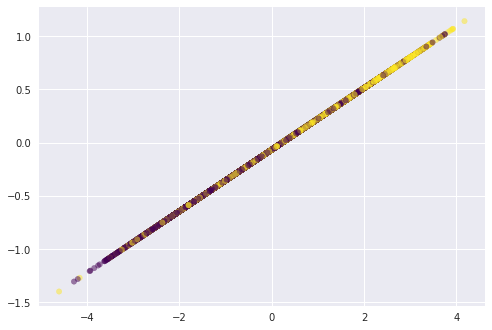

In [11]:
plt.scatter(x_a, alphas[0] + np.sum(betas[0] * x_a, 1), 30, y_a, cmap='viridis', alpha=0.5)

In [12]:
y_a[x_a.squeeze() < 0].mean()

0.42034537395455185

In [13]:
x_a.shape

(100000, 1)

In [14]:
y_a.shape

(100000,)

In [15]:
x_b = np.random.randn(num_samples, num_features)

In [16]:
y_b = np.random.binomial(1, numpy_invlogit(alphas[1] + np.sum(betas[1] * x_b, 1)))

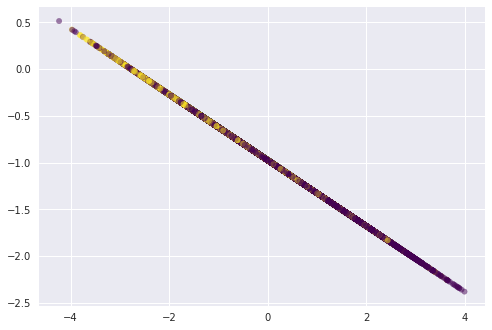

In [17]:
plt.scatter(x_b, alphas[1] + np.sum(betas[1] * x_b, 1), 30, y_b, cmap='viridis', alpha=0.5)

In [18]:
y_b[x_b.squeeze() >= 0].mean()

0.22096379745820471

In [19]:
x_c = np.random.randn(num_samples, num_features)

In [20]:
y_c = np.random.binomial(1, numpy_invlogit(alphas[2] + np.sum(betas[2] * x_c, 1)))

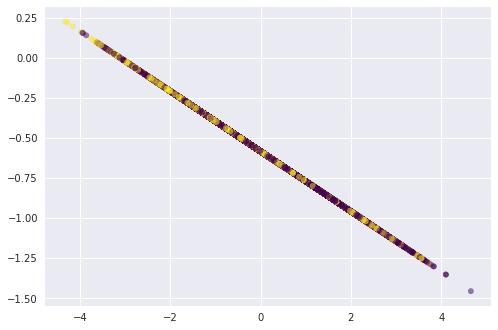

In [21]:
plt.scatter(x_c, alphas[2] + np.sum(betas[2] * x_c, 1), 30, y_c, cmap='viridis', alpha=0.5)

In [22]:
X = np.concatenate([x_a, x_b, x_c])

In [23]:
X.shape

(300000, 1)

In [24]:
Y = np.concatenate([y_a, y_b, y_c])

In [25]:
Y.shape

(300000,)

In [26]:
markets = np.concatenate([np.zeros(num_samples, dtype=np.int), np.ones(num_samples, dtype=np.int), 2*np.ones(num_samples, dtype=np.int)])

In [27]:
markets.dtype

dtype('int64')

In [28]:
markets.shape

(300000,)

In [29]:
X_train, X_test, market_train, market_test, Y_train, Y_test = train_test_split(X, markets, Y, test_size=0.4)

In [30]:
X_train.shape

(180000, 1)

In [31]:
market_train.shape

(180000,)

Train Model
===

In [32]:
HLM = SoothsayerHLM()

In [33]:
HLM.fit(X_train, market_train, Y_train)

100%|██████████| 7500/7500 [00:00<00:00, 7814.22it/s]


SoothsayerHLM()

In [34]:
HLM.v_params

ADVIFit(means={'beta': array([[ 0.27979786],
       [-0.3711209 ],
       [-0.18225689]]), 'sigma_beta_log_': array(-0.38203042567998524), 'sigma_alpha_log_': array(-0.11924675185234801), 'mu_alpha': array([-0.61657558]), 'alpha': array([-0.10156787, -0.98868655, -0.57800438]), 'mu_beta': array([-0.08137736])}, stds={'beta': array([[ 0.00882644],
       [ 0.01100418],
       [ 0.00954387]]), 'sigma_beta_log_': 0.60764712762694728, 'sigma_alpha_log_': 0.62899567258729072, 'mu_alpha': array([ 0.45085903]), 'alpha': array([ 0.01010841,  0.00834806,  0.01005199]), 'mu_beta': array([ 0.36234675])}, elbo_vals=array([-133560.42187415, -125543.49737639, -132807.99168939, ...,
       -122430.51447015, -115235.24571069, -133706.87489612]))

In [35]:
HLM.v_params.means['alpha']

array([-0.10156787, -0.98868655, -0.57800438])

In [36]:
alphas

array([-0.06641087, -0.97587589, -0.58375764])

In [37]:
np.testing.assert_almost_equal(alphas, HLM.v_params.means['alpha'], decimal=1)

In [38]:
betas

array([[ 0.2892241 ],
       [-0.35215048],
       [-0.18745879]])

In [39]:
HLM.v_params.means['beta']

array([[ 0.27979786],
       [-0.3711209 ],
       [-0.18225689]])

In [40]:
HLM.v_params.stds['beta']

array([[ 0.00882644],
       [ 0.01100418],
       [ 0.00954387]])

In [41]:
np.testing.assert_allclose([0.1, 0.3], [0.2, 0.4], atol=0.5)

In [42]:
np.testing.assert_allclose(HLM.v_params.means['beta'], betas, atol=0.6)

In [43]:
np.testing.assert_almost_equal(betas, HLM.v_params.means['beta'], decimal=1)

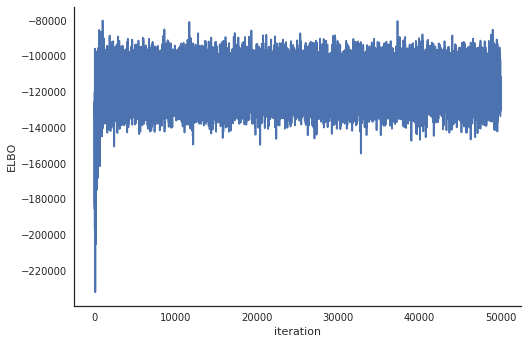

In [44]:
HLM.plot_elbo()

In [45]:
summary(HLM.advi_trace)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.619           0.451            0.005            [-1.549, 0.227]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.515         -0.924         -0.622         -0.312         0.265


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.082           0.361            0.004            [-0.805, 0.615]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.790         -0.323         -0.081         0.161          0.640


alpha:

  Mean             SD               MC Error         95% HPD interval
  ------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2f6407090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff2f5f0bdd0>]], dtype=object)

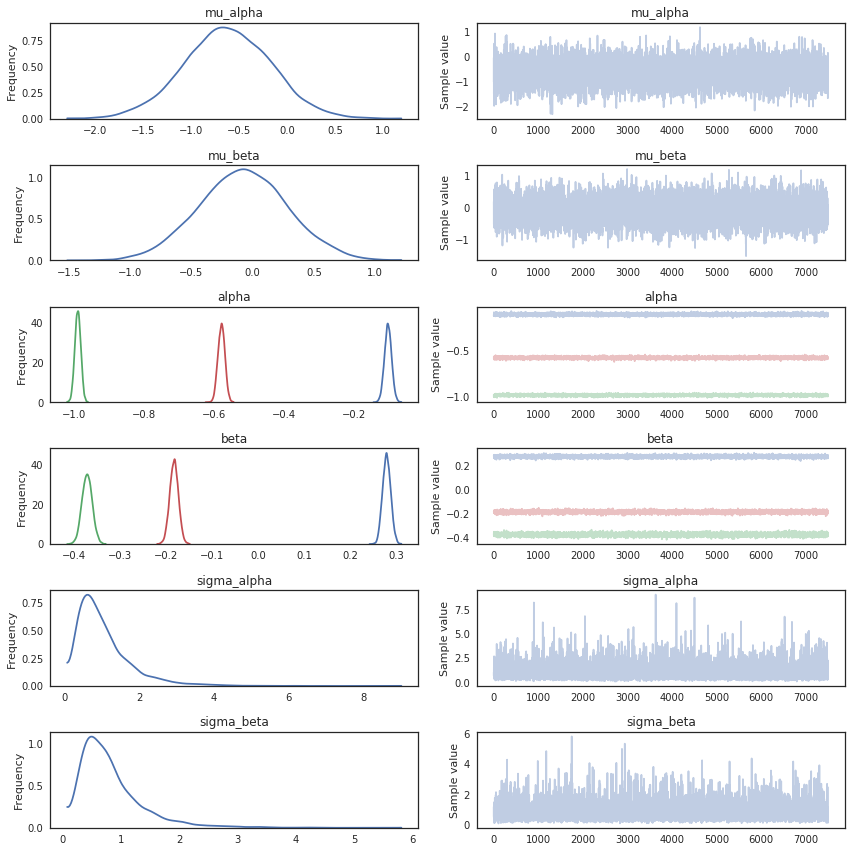

In [46]:
traceplot(HLM.advi_trace)

In [47]:
HLM.score(X_train, market_train, Y_train)

100%|██████████| 2000/2000 [00:59<00:00, 33.53it/s]


0.64133333333333331

In [48]:
unique, counts = np.unique(Y_train, return_counts=True)

In [49]:
unique

array([0, 1])

In [50]:
counts/len(Y_train)

array([ 0.62920556,  0.37079444])

Test Data
===

In [51]:
HLM.score(X_test, market_test, Y_test)

100%|██████████| 2000/2000 [00:42<00:00, 46.84it/s]


0.64059166666666667

In [52]:
unique, counts = np.unique(Y_test, return_counts=True)

In [53]:
counts/len(Y_test)

array([ 0.62759167,  0.37240833])

In [54]:
HLM.v_params.means.keys()

['beta', 'sigma_beta_log_', 'sigma_alpha_log_', 'mu_alpha', 'alpha', 'mu_beta']

In [55]:
type(HLM.v_params.means)

dict